In [3]:
import os
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import scipy.optimize as optimize
from findiff import FinDiff, coefficients, Coefficient

In [4]:
# SET THE WORKING DIRECTORY
CWD = '/Users/miguel/Documents/Internship_CENTURI'
os.chdir(CWD)

In [5]:
## DEFINES WORKING CONSTANTS
#FILENAME = args.filename
FILENAME = 'plate_counts.csv'
SAVE_FN = FILENAME.strip().split('.')[0]
START = 105 # Start of the linear portion of the graph
ALPH_DICT = {'A':0, 'B':1, 'C':2, 'D':3, 'E':3, 'F':5, 'G':6, 'H':7}

In [10]:
FILE_PATH = os.path.join(os.getcwd(), "data", FILENAME)
print(FILE_PATH)
df = pd.read_csv(FILE_PATH)

/Users/miguel/Documents/Internship_CENTURI/data/plate_counts.csv


In [11]:
df.head()

,founder,replicate,day,cfuml,percent_large,percent_small,percent_total,frac_large,frac_small,num_large,num_small
0,SBW25,3,0,1.766667e+09,100.0,0.0,100,1.0,0.0,1.766667e+09,0.000000e+00
1,SBW25,4,0,1.986667e+09,100.0,0.0,100,1.0,0.0,1.986667e+09,0.000000e+00
2,delserCGA,3,0,6.866667e+08,0.0,100.0,100,0.0,1.0,0.000000e+00,6.866667e+08
3,delserCGA,4,0,1.406667e+09,0.0,100.0,100,0.0,1.0,0.000000e+00,1.406667e+09
4,delEGEG,3,0,8.000000e+08,0.0,100.0,100,0.0,1.0,0.000000e+00,8.000000e+08


In [27]:
# Get data from dataframe
founder = df.founder.unique()
# Upon inspection all strains have 4 replicates, thus
n_replicates = 4

In [19]:
df.sort_values(['founder', 'replicate'])

,founder,replicate,day,cfuml,percent_large,percent_small,percent_total,frac_large,frac_small,num_large,num_small
84,SBW25,1,0,1.653333e+09,100.000000,0.000000,100,1.000000,0.000000,1.653333e+09,0.0
90,SBW25,1,1,2.913333e+09,100.000000,0.000000,100,1.000000,0.000000,2.913333e+09,0.0
96,SBW25,1,2,2.513333e+09,100.000000,0.000000,100,1.000000,0.000000,2.513333e+09,0.0
102,SBW25,1,3,1.968000e+09,100.000000,0.000000,100,1.000000,0.000000,1.968000e+09,0.0
108,SBW25,1,4,1.744000e+09,100.000000,0.000000,100,1.000000,0.000000,1.744000e+09,0.0
...,...,...,...,...,...,...,...,...,...,...,...
614,delserCGA,4,85,1.944000e+09,99.176955,0.823045,100,0.991770,0.008230,1.928000e+09,16000000.0
626,delserCGA,4,88,2.200000e+09,99.636364,0.363636,100,0.996364,0.003636,2.192000e+09,8000000.0
638,delserCGA,4,92,2.048000e+09,99.218750,0.781250,100,0.992188,0.007812,2.032000e+09,16000000.0
650,delserCGA,4,95,2.272000e+09,99.295775,0.704225,100,0.992958,0.007042,2.256000e+09,16000000.0


Let's start by plotting the first strain only, SBW25

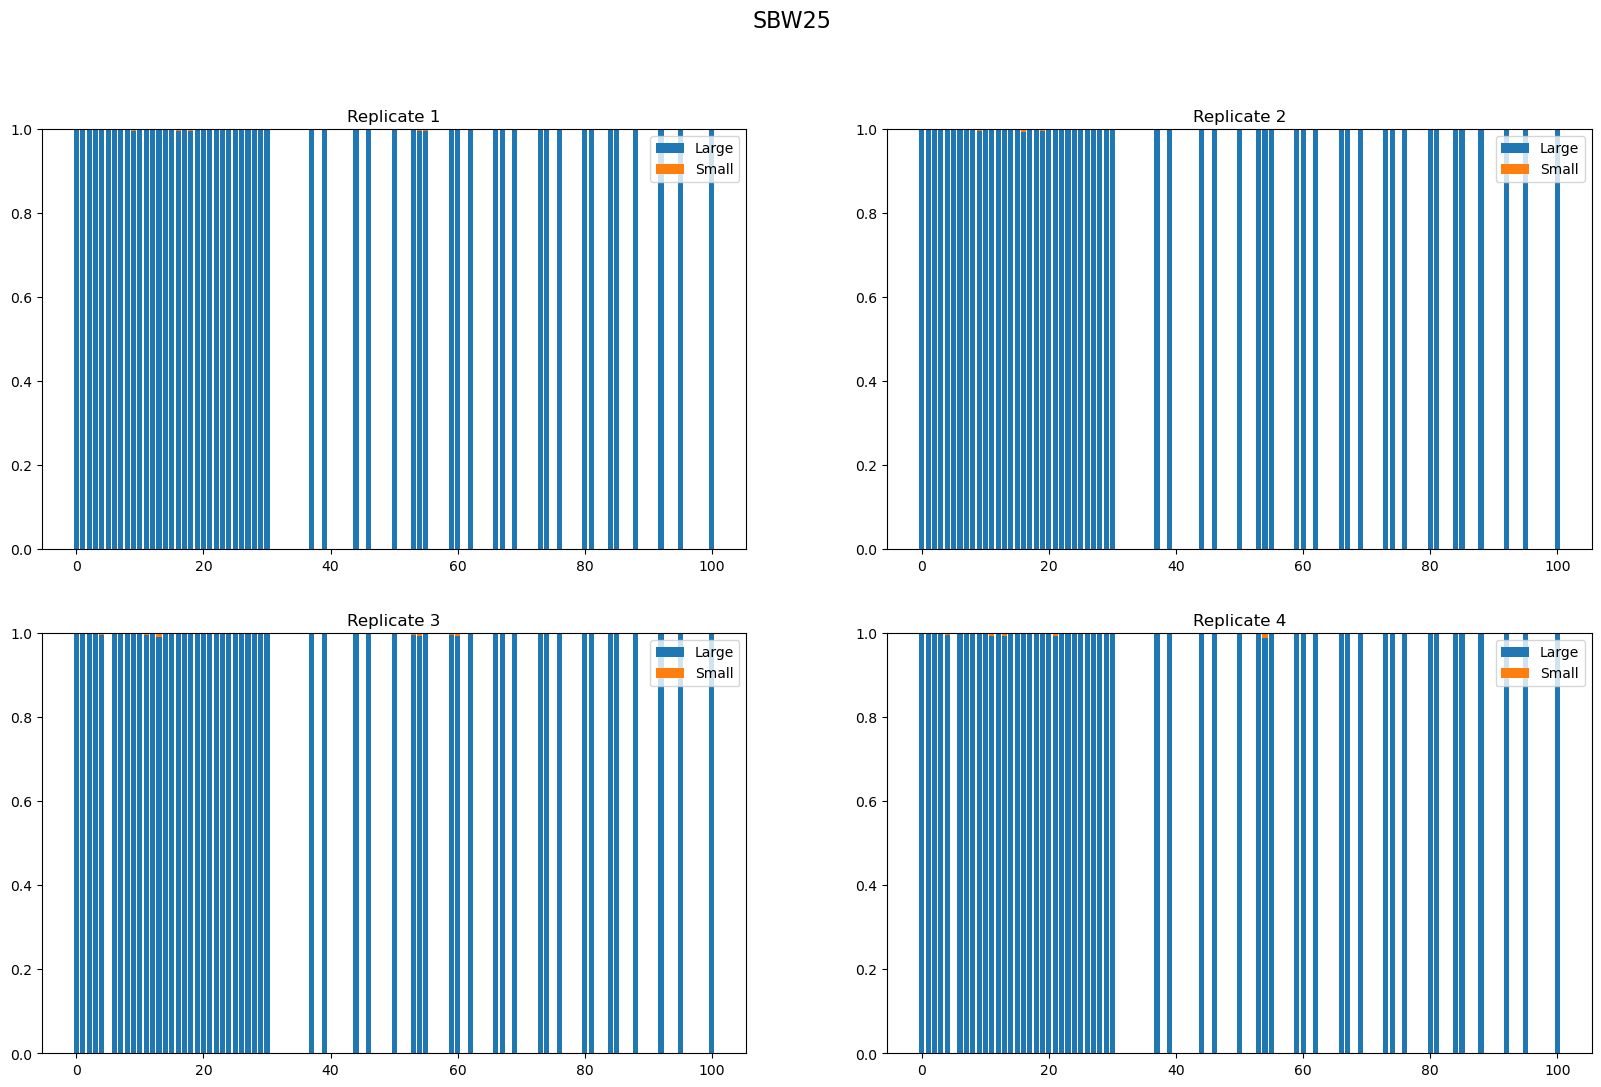

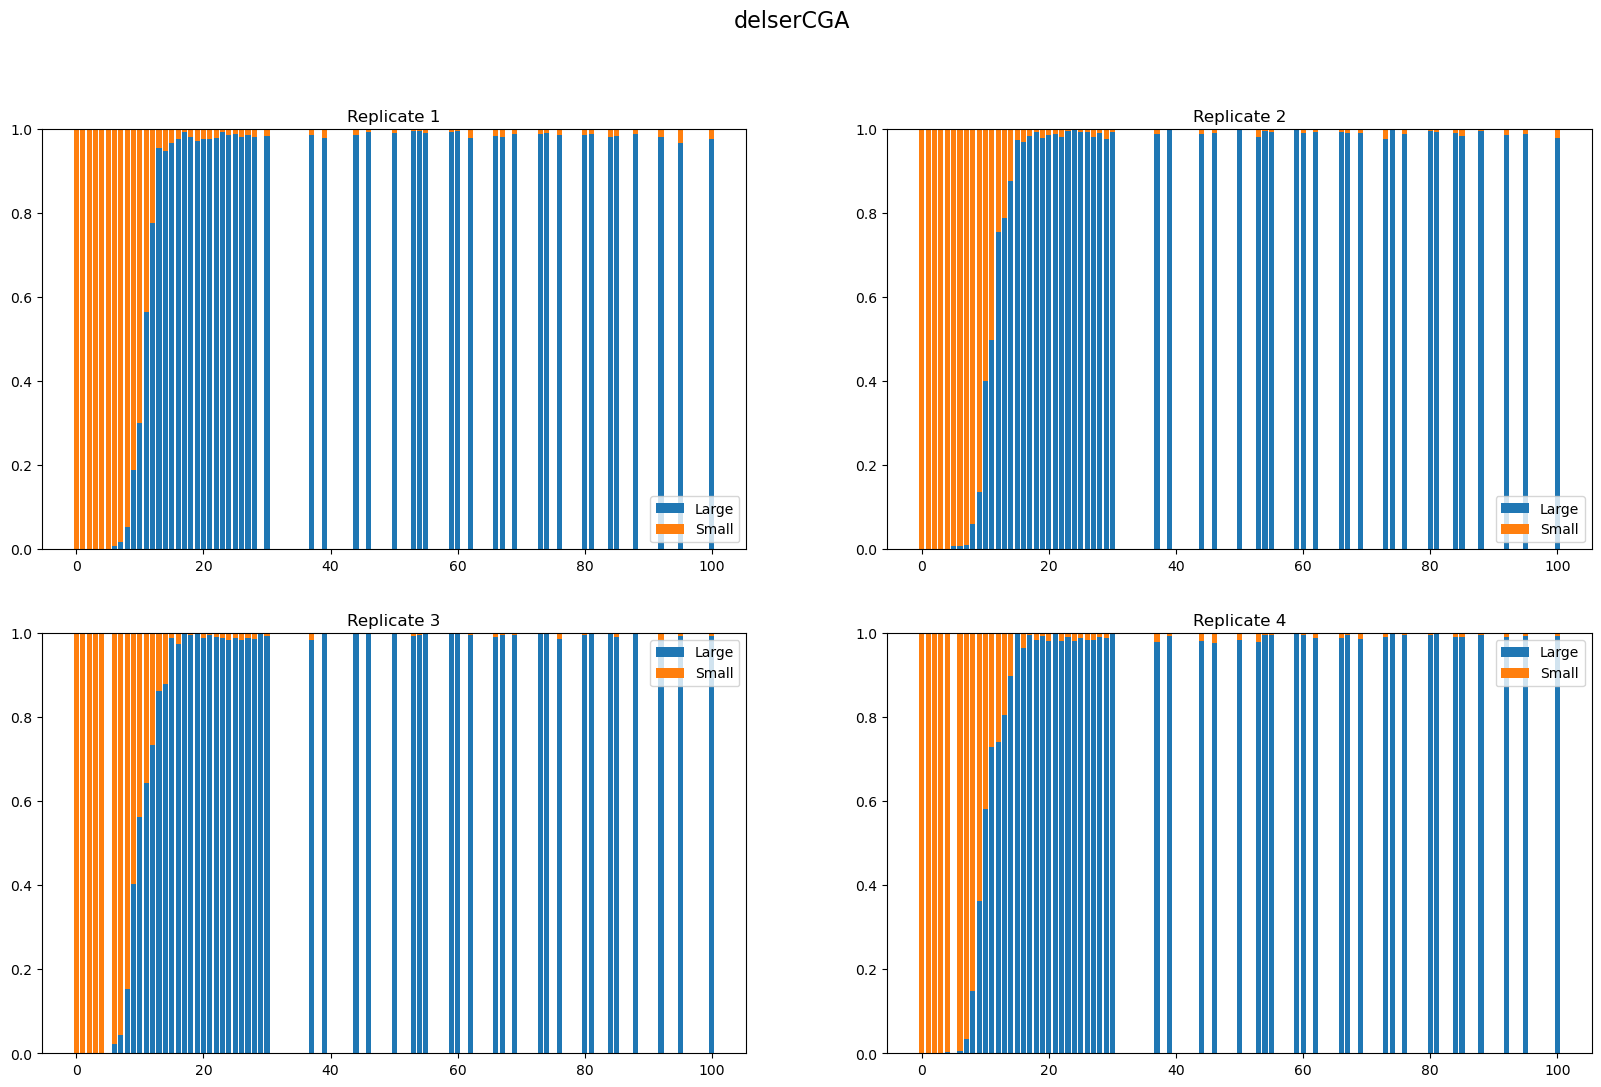

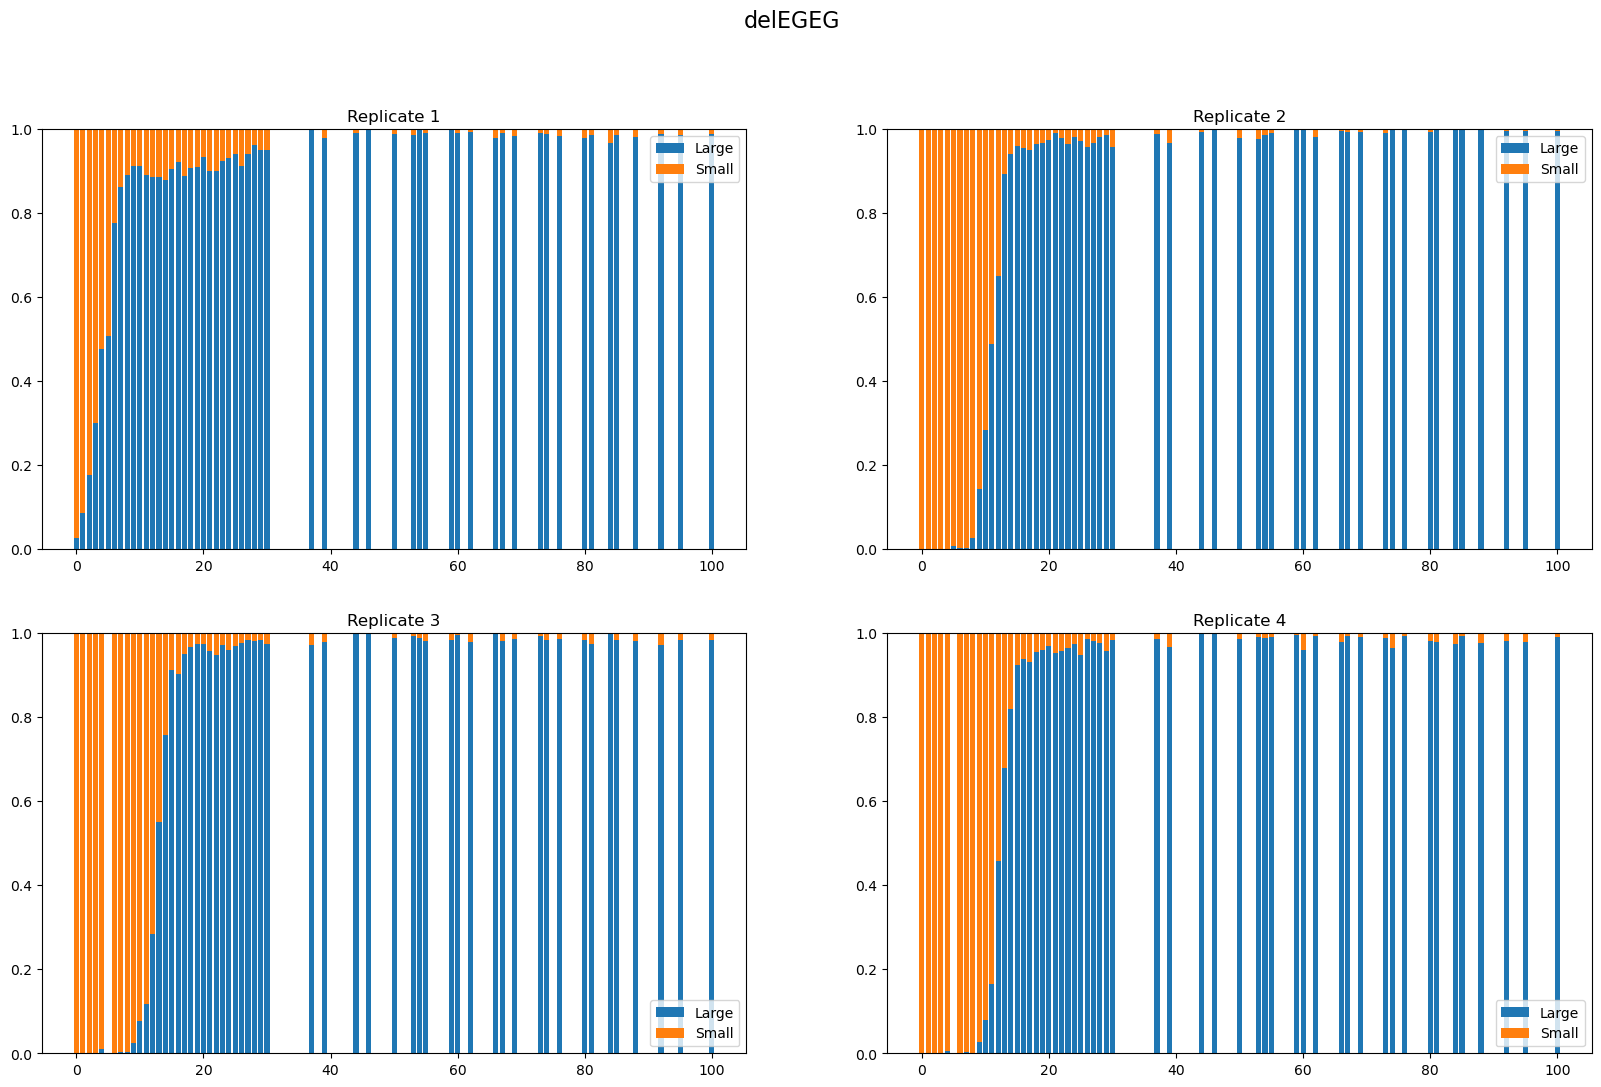

In [64]:
nrows = n_replicates//2
for strain in founder:
    fig, ax = plt.subplots(nrows = nrows, ncols = 2, figsize = (20, 6 * nrows), sharex = False)
    fig.suptitle(strain, fontsize=16)
    for i, axes in enumerate(ax.flat):
        temp_df = df[(df.founder == strain) & (df.replicate == i + 1)]
        axes.bar(temp_df.day.values, temp_df.frac_large.values,  label = 'Large')
        axes.bar(temp_df.day.values, temp_df.frac_small.values, bottom = temp_df.frac_large.values , label = 'Small')
        axes.set_ylim([0, 1])
        axes.legend();
        axes.set_title("Replicate " + str(i + 1))


## Plot scatter and lines instead

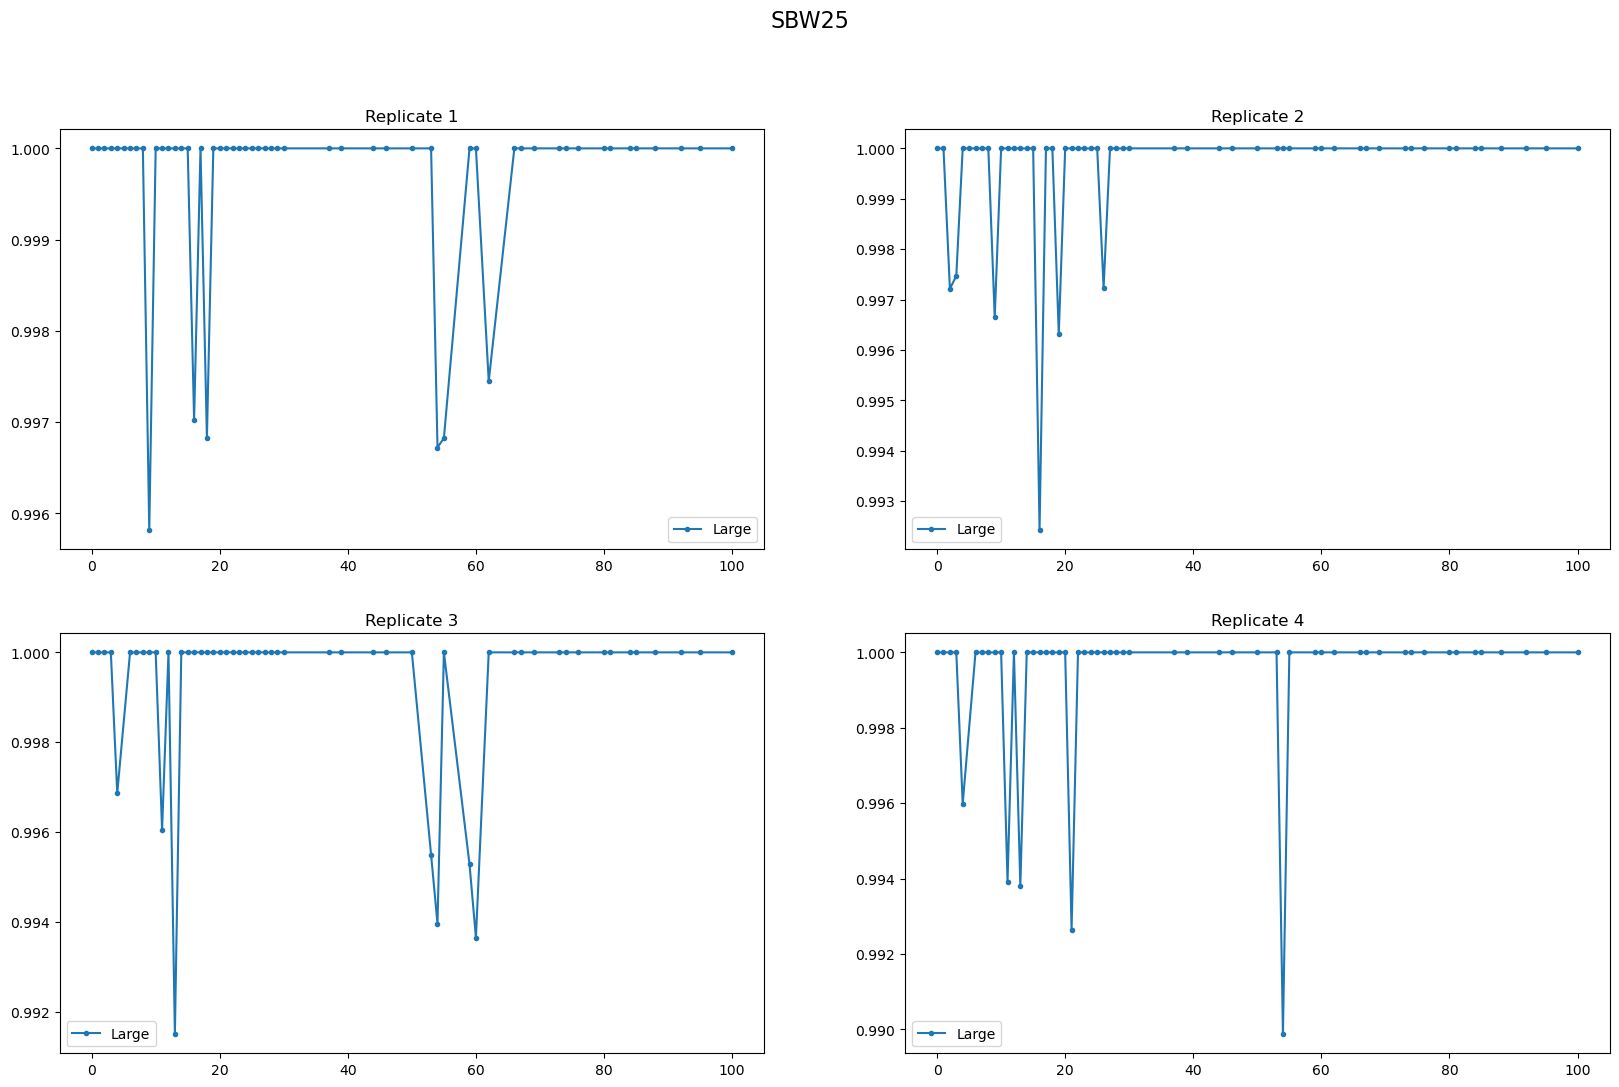

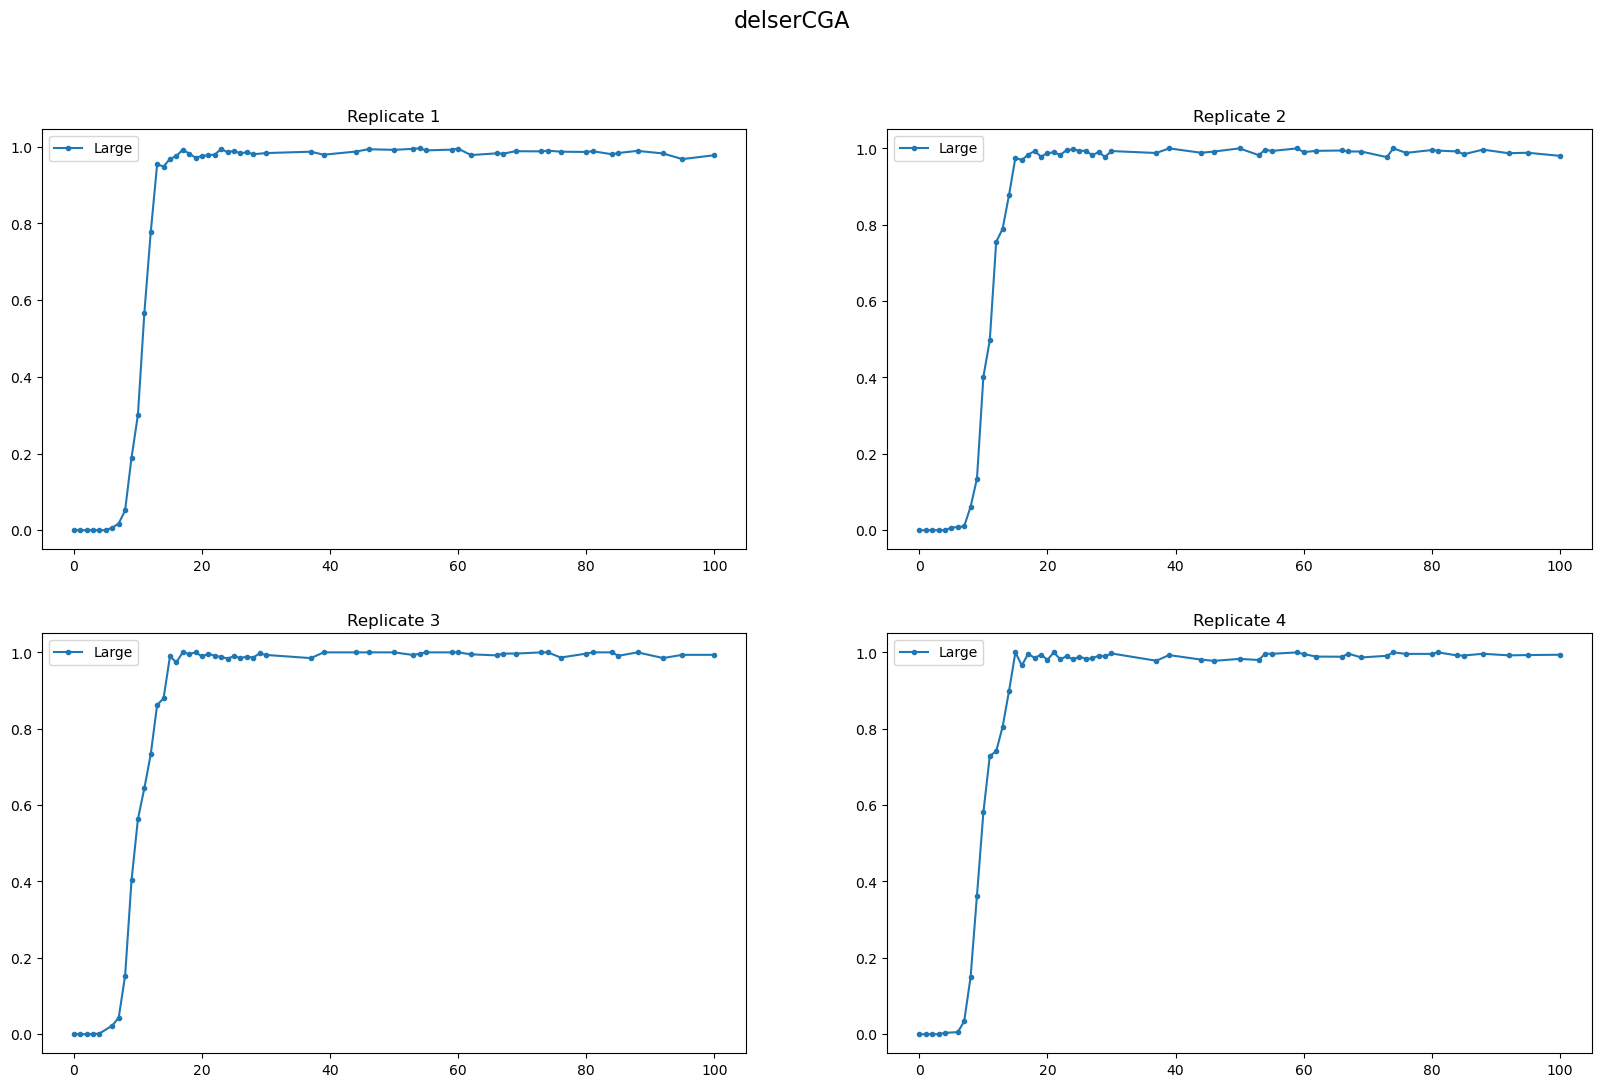

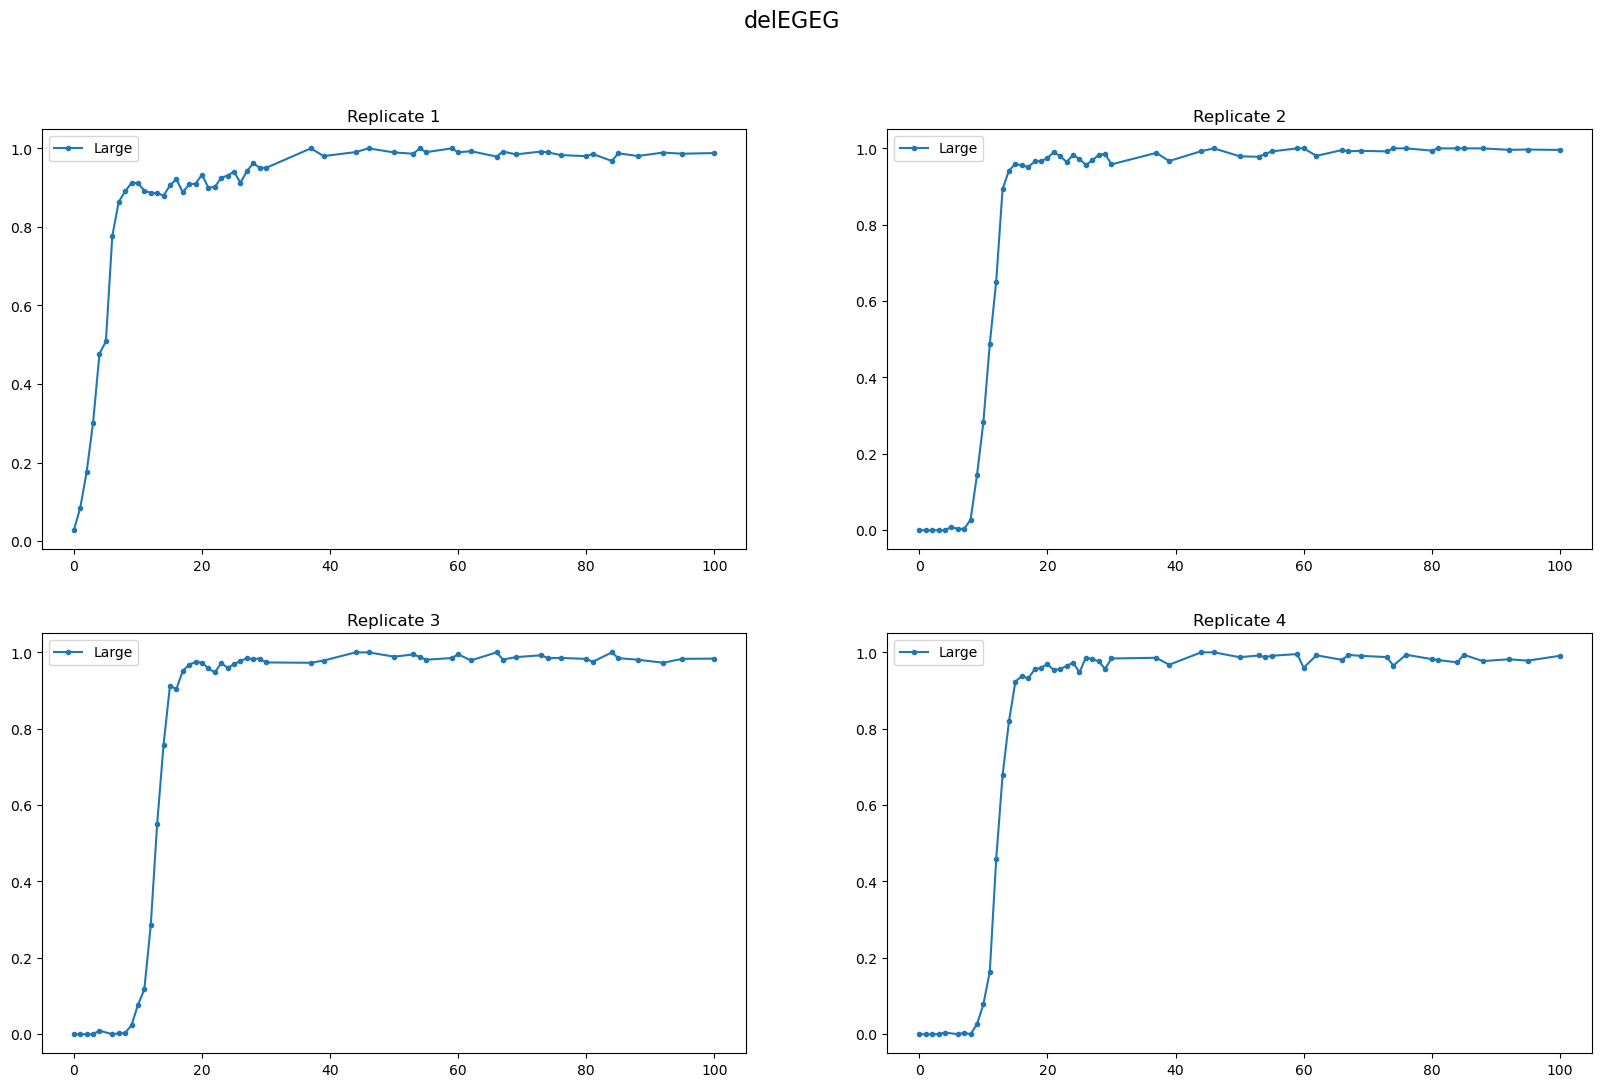

In [74]:
nrows = n_replicates//2
for strain in founder:
    fig, ax = plt.subplots(nrows = nrows, ncols = 2, figsize = (20, 6 * nrows), sharex = False)
    fig.suptitle(strain, fontsize=16)
    for i, axes in enumerate(ax.flat):
        temp_df = df[(df.founder == strain) & (df.replicate == i + 1)]
        axes.plot(temp_df.day.values, temp_df.frac_large.values, '.-', label = 'Large')
        #axes.set_ylim([0, 1])
        axes.legend();
        axes.set_title("Replicate " + str(i + 1))

First, let's fit the models above to a logistic growth function

In [75]:
from lmfit.models import ExpressionModel, StepModel, LinearModel
import lmfit

In [92]:
gmodel = StepModel(form = 'logistic')
gmodel.set_param_hint('center', value = 10)

In [99]:
X = df[(df.founder == 'delserCGA') & (df.replicate == 1)][['day','frac_large']]
result = gmodel.fit(X.frac_large.values, x=X.day.values)

In [100]:
std = result.eval_uncertainty(x=X.day.values)

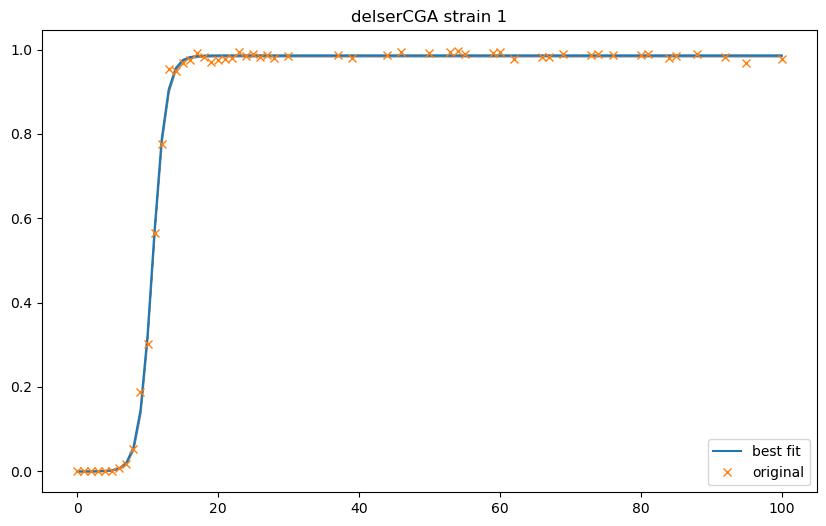

In [103]:
plt.figure(figsize = (10,6))
plt.plot(X.day.values, result.best_fit, '-', label='best fit')
plt.plot(X.day.values, X.frac_large.values, 'x', label='original')
plt.fill_between(X.day.values, result.best_fit-std,result.best_fit+std, color='#888888')
plt.legend(loc = 'lower right');
plt.title('delserCGA strain 1');

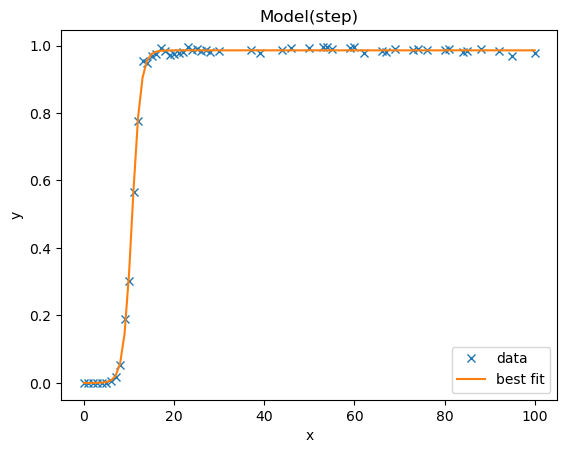

In [109]:
result.plot_fit(datafmt='x');

In [111]:
result.best_values

{'form': 'logistic',
 'amplitude': 0.9857547985812843,
 'center': 10.684203333123712,
 'sigma': 0.957957137779284}

In [123]:
result.summary()['best_values']

{'form': 'logistic',
 'amplitude': 0.9770223629104517,
 'center': 12.26128078846285,
 'sigma': 0.9421573817044889}

In [116]:
df[(df.founder == 'delserCGA') & (df.replicate == 0)][['day','frac_large']]

,day,frac_large


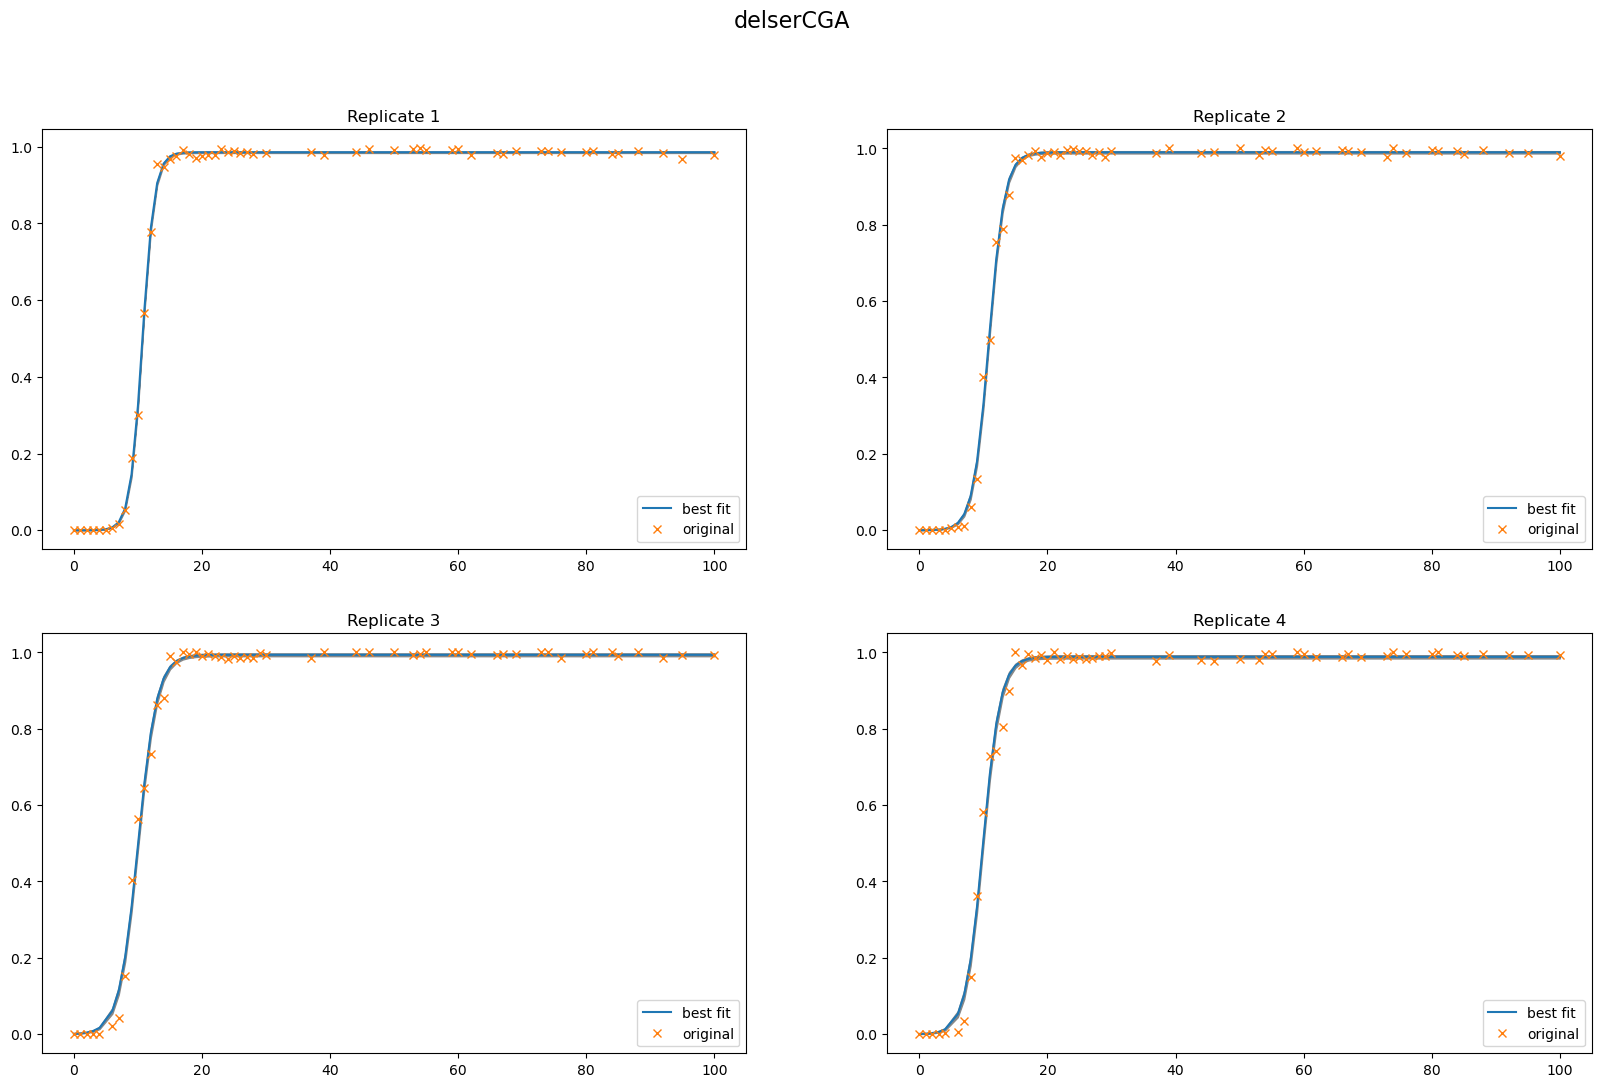

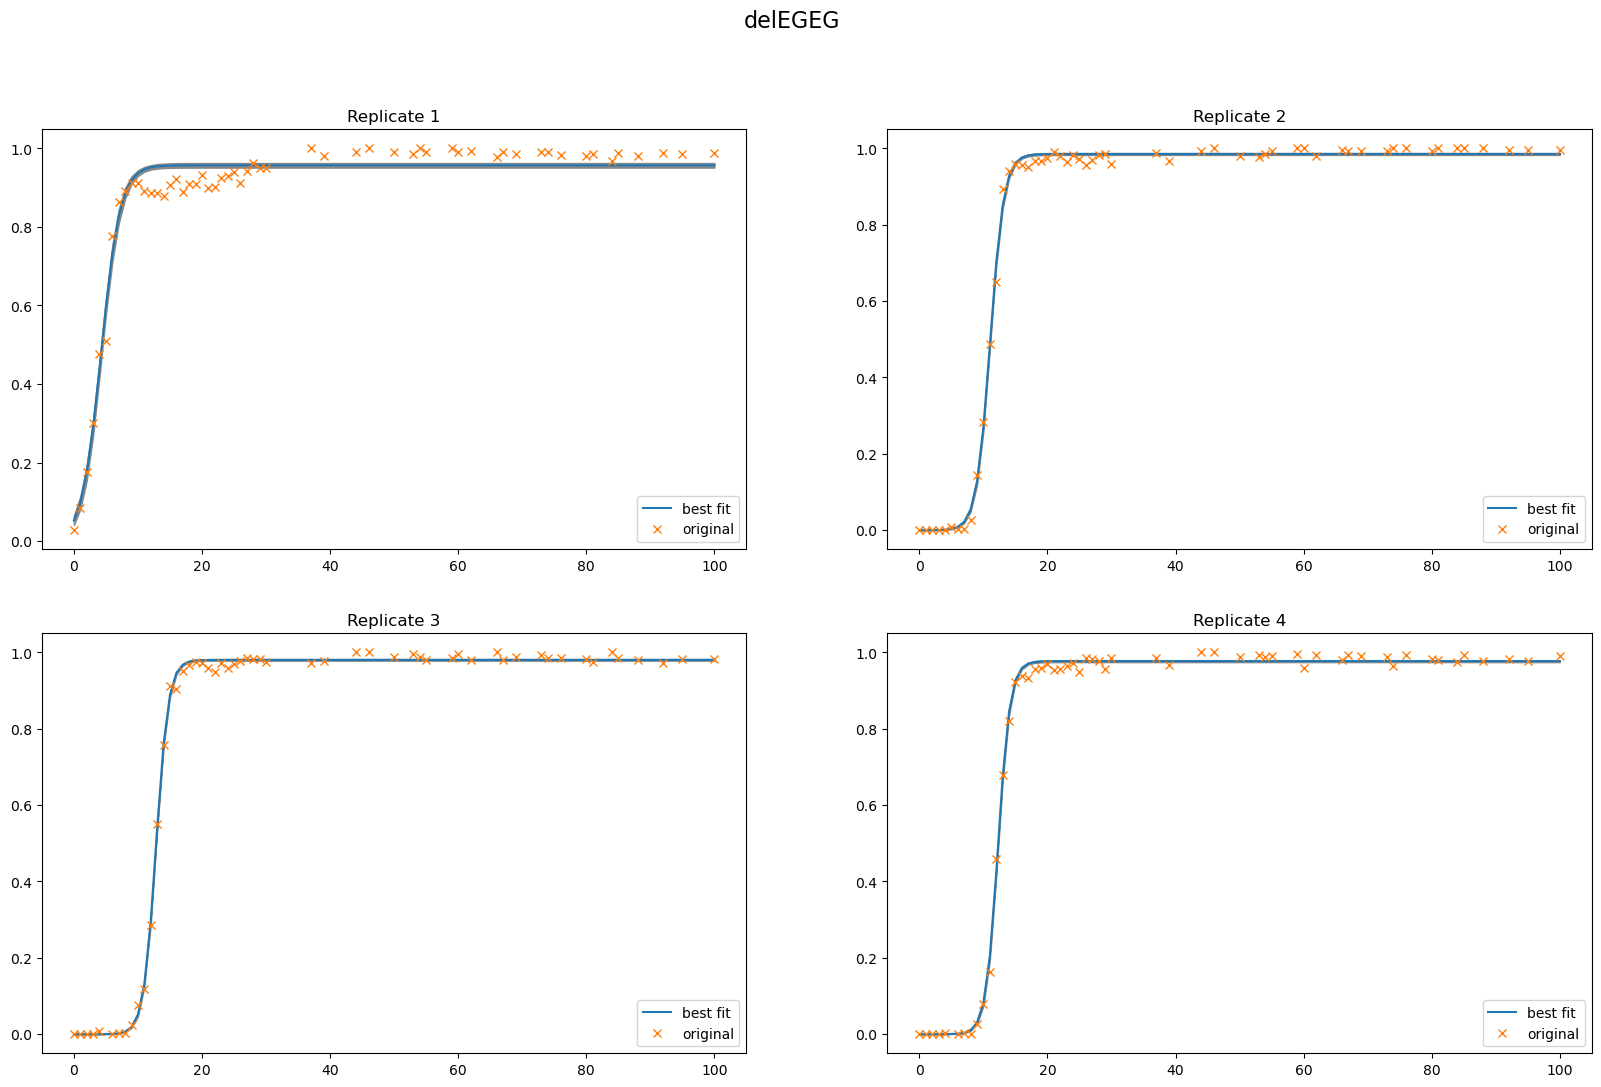

In [124]:
nrows = n_replicates//2
resultados = {}
for strain in founder[1:]:
    temp_dict ={}

    fig, ax = plt.subplots(nrows = nrows, ncols = 2, figsize = (20, 6 * nrows), sharex = False)
    fig.suptitle(strain, fontsize=16)
    for i, axes in enumerate(ax.flat):
        # Defining the model
        gmodel = StepModel(form = 'logistic')
        # Guess of the initial parameter based on visual inspection of the plots
        gmodel.set_param_hint('center', value = 10)
        # Store the information of each replica
        X = df[(df.founder == strain) & (df.replicate == i + 1)][['day','frac_large']]
        result = gmodel.fit(X.frac_large.values, x=X.day.values)
        std = result.eval_uncertainty(x=X.day.values)
        
        # Save the summary of the fit to a dictionary
        temp_dict[i+1] = result.summary()

        axes.plot(X.day.values, result.best_fit, '-', label='best fit')
        axes.plot(X.day.values, X.frac_large.values, 'x', label='original')
        axes.fill_between(X.day.values, result.best_fit - std, result.best_fit + std, color='#888888')
        axes.legend(loc = 'lower right');
        axes.set_title("Replicate " + str(i + 1));
    resultados[strain] = temp_dict

In [137]:
np.array([resultados.get('delserCGA')[i]['best_values']['center'] for i in range(1,5)]).mean()

10.371162142534564

Let's try to get the transition rates for the different strains

In [58]:
founder

array(['SBW25', 'delserCGA', 'delEGEG'], dtype=object)

In [70]:
temp_df = df[df.founder == 'SBW25']

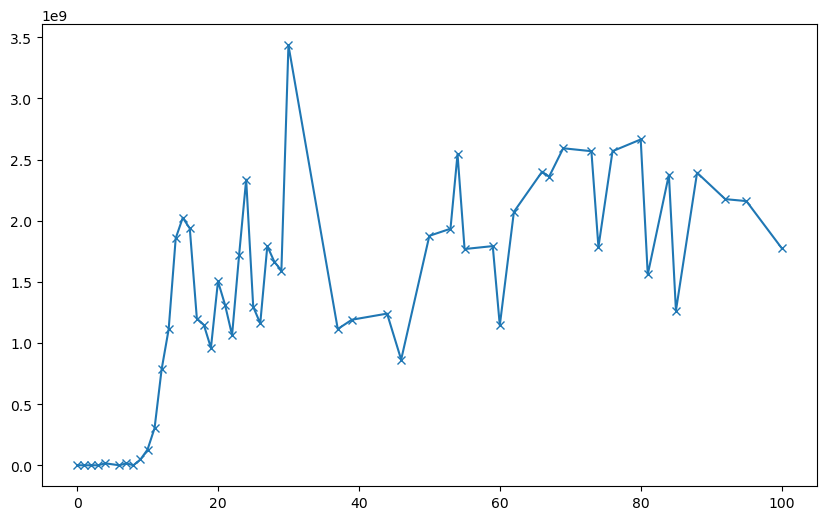

In [143]:
plt.figure(figsize = (10, 6))
plt.plot(temp_df.day.values,temp_df.num_large.values, 'x-')

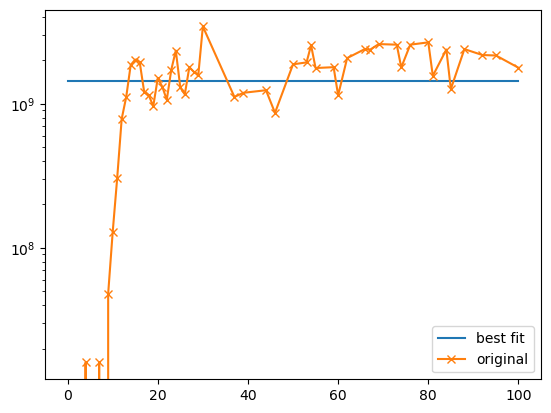

In [153]:
test_model = StepModel(form = 'logistic')
# Guess of the initial parameter based on visual inspection of the plots
test_model.set_param_hint('center', value = 10)
test_model.set_param_hint('amplitude', value = 2e9)
test_model.set_param_hint('sigma', value = 1e3)
# Store the information of each replica

test_result = gmodel.fit(temp_df.num_large.values, x=temp_df.day.values)
test_std = test_result.eval_uncertainty(x=temp_df.day.values)

plt.plot(temp_df.day.values, test_result.best_fit, '-', label='best fit')
plt.semilogy(temp_df.day.values, temp_df.num_large.values, 'x-', label='original')
#plt.fill_between(temp_df.day.values, test_result.best_fit - test_std, result.best_fit + test_std, color='#888888')
plt.legend(loc = 'lower right');

In [150]:
resultados.get('delserCGA')[1]['best_values']

{'form': 'logistic',
 'amplitude': 0.9857547985812843,
 'center': 10.684203333123712,
 'sigma': 0.957957137779284}

In [175]:
1/0.957957137779284

1.043888041085198

Let's first solve the equations by varying the parameters

In [171]:
def model_eqs(vars, t, *params):
    # Unpack the model parameters and variables
    temp_vars = vars
    r_f, r_c, r_fc, r_cf = params
    
    M = np.array([[r_f * (1 - r_fc), r_cf * r_c], [r_f * r_fc, r_c * (1 - r_cf)]])
    
    return M.dot(temp_vars)



In [194]:
def model_eqs_K(vars, t, *params):
    # Unpack the model parameters and variables
    temp_vars = vars
    r_f, r_c, r_fc, r_cf, K = params
    
    M = np.array([[r_f * (1 - r_fc), r_cf * r_c], [r_f * r_fc, r_c * (1 - r_cf)]])
    
    return M.dot(temp_vars) * (1- temp_vars.sum() / K)


In [204]:
# Time
t_span = np.linspace(0, 100, 1000)
# Initial conditions of the problem
# [F0, C0]
# In a scale onf 10^9
p0 = np.array([1, 0])

# Parameters()
# r_F : Obtained from growth curves fit = 1.04388
# Mutations per generation for wild type (https://doi.org/10.1093/gbe/evu284)
# 4.25 × 10−9
# K: 0.9857
# r_c, r_fc, r_cf : need to be obtained by varying parameters in the equations
# let's use a random value just to see how the solver does

infer_params = (1.04388, 1.04388, 0.5, 0.5)
infer_params_K = (1.04388, 1.04388, 0.5, 0.5, 10)

In [193]:
np.array(infer_params).sum()

3.08776

In [188]:
from scipy.integrate import odeint

sol = odeint(model_eqs, p0, t_span, args=infer_params)

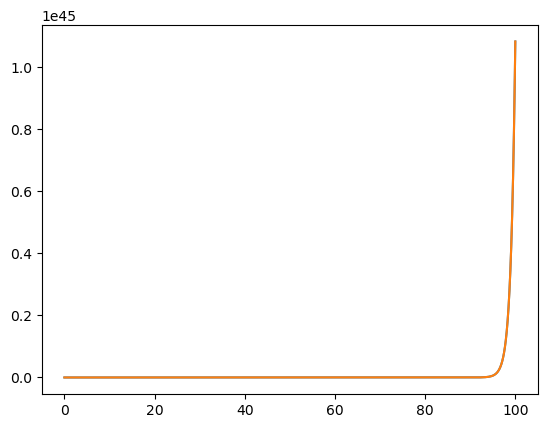

In [203]:
plt.plot(t_span, sol)

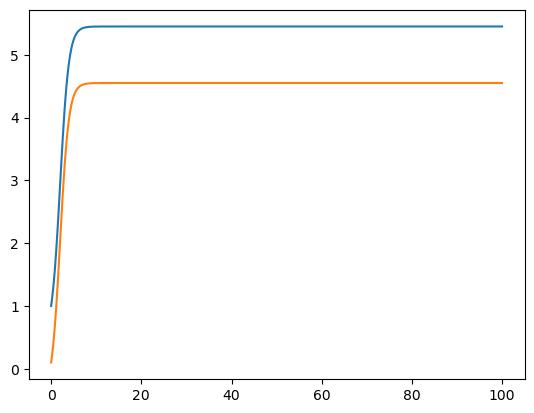

In [205]:
p0_K = np.array([1, 0.1])
sol_K = odeint(model_eqs_K, p0_K, t_span, args=infer_params_K)
plt.plot(t_span, sol_K)

In [200]:
sol_K

array([[1.        , 0.1       ],
       [0.99374414, 0.09374414],
       [0.98822955, 0.08822955],
       ...,
       [0.94285   , 0.04285   ],
       [0.94285   , 0.04285   ],
       [0.94285   , 0.04285   ]])

In [460]:
class Model():
    '''
    Takes as input:
        name: name of the model
        t: time array
        params: dictionary with 5 parameters, the replication rates(r_f,r_c), transition rates(mu_fc, mu_cf), carrying capacity(K)
    '''

    def __init__(self, name, time, params) -> None:
        self.name = name
        #time
        self.time = time
        
        # Parameters of the model
        self.r_f = params['r_f']
        self.mu_fc = params['mu_fc']
        # Optional parameters if chosed to vary
        self.r_c = params.get('r_c', 0)
        self.mu_cf = params.get('mu_cf', 0)
        self.K = params['K']

        # Solution of the model
        self.sol = 0
    
    def equations(self, vars, t):
        # Define the system of equations     
        M = np.array([[self.r_f * (1 - self.mu_fc), self.mu_cf * self.r_c], [self.r_f * self.mu_fc, self.r_c * (1 - self.mu_cf)]])
        return M.dot(vars) * (1- vars.sum() / self.K)

    def solve(self, p0):
        # Solve the system
        sol = odeint(self.equations, y0 = p0, t = self.time)
        self.sol = sol

    def plot_sol(self, ax):
        ax.plot(self.time, self.sol, label = ['F', 'C'])
        ax.set_title(self.name)
        #ax.set_ylabel('Population(x10^8)')
        #ax.set_xlabel('Time')
        ax.legend()
        return ax
    
    def plot_frac(self, ax):
        temp_frac = self.sol / self.sol.sum(axis = 1)[:, None]
        ax.plot(self.time, temp_frac, label = ['F', 'C'])
        ax.set_title(self.name)
        #ax.set_ylabel('Population(x10^8)')
        #ax.set_xlabel('Time')
        ax.legend()
        return ax

    def __str__(self) -> str:
        return "name : {} \nparameters (r_f : {}, mu_fc : {}, r_c : {}, mu_cf : {}, K : {}) \n \
                ".format(self.name, self.r_f, self.mu_fc, self.r_c, self.mu_cf, self.K)


## Let's determine some of the initial parameters of the model

### Determine a better value for the carrying capacity
This parameter turns out to be very relevant for the behavior of the populations

In [368]:
def OD_to_cell_ml(od):
    ## Information retrieved from 
    ## https://doi.org/10.1371/journal.pone.0276040.g002
    ## To convert from OD to cell/mL they fitted a fourth degree polynomial
    ## Coefficients vary among bacterial strains, I will implement them all here to compare results
    ## Equations for plate size of 96, the one used in our experiment

    # Dictionary to store the results
    coef = {}

    # S. epidermidis
    coef[1] = 4.3e10 * od**4 - 3.8e10 * od**3 + 1.2e10 * od**2 + 1.7e10 * od + 1.7e8
    # E. coli
    coef[2] = 1.6e9 * od**4 - 2.3e9 * od**3 + 1.3e9 * od**2 + 1e9 * od + 5.1e5
    # P. putida
    coef[3] = 2.4e8 * od**4 - 2.7e8 * od**3 + 6.4e7 * od**2 + 4.7e8 * od + 1.4e8
    # B. megaterium
    coef[4] = 4.4e8 * od**4 - 4.9e8 * od**3 + 3.2e8 * od**2 + 5.9e8 * od + 4.3e6
    
    return coef


Let's take a look at the results when applied for our strand, using one of the carrying capacities estimated from OD data

In [372]:
np.array(list(OD_to_cell_ml(0.9857).values()))

array([3.27858104e+10, 1.55698604e+09, 6.33443508e+08, 8.42864995e+08])

The orders of magnitude are quite different, for the sake of a first attempt I will use the average of such values as the carrying capacity (scaled down by 10^8 for computation purposes)

In [398]:
delserCGA_path = os.path.join(os.getcwd(), "data", 'fit_gc_delserCGA.csv')
df_fit_delserCGA = pd.read_csv(delserCGA_path, index_col=0)

In [412]:
K_means = [np.array(list(i.values())).mean() for i in df_fit_delserCGA.loc['K'].map(lambda x:OD_to_cell_ml(x)).values]

In [414]:
K_mean = np.array(K_means).mean()/10**8
print(K_mean)

21.39022292452527


In [213]:
# From the curve fit
# r_f = 1.04388
# Mutations per generation for wild type (https://doi.org/10.1093/gbe/evu284) 
# mu_fc = 4.25 × 10^−9
# K: 124000 × 10^8

In [456]:
test_time = np.linspace(0, 100, 1000)
test_params = {'r_f' : 1.04388, 'mu_fc' : 4.25e-9, 'K' : 21.31}
test_model = Model('delserCGA', test_time, test_params)

In [416]:
test_model.mu_cf = 4.25e-9
test_model.r_c = 2

In [417]:
print(test_model)

name : delserCGA 
parameters (r_f : 1.04388, mu_fc : 4.25e-09, r_c : 2, mu_cf : 4.25e-09, K : 21.31) 
                 


In [424]:
test_p0 = np.array([0.01, 0.001])
test_model.solve(p0 = test_p0)

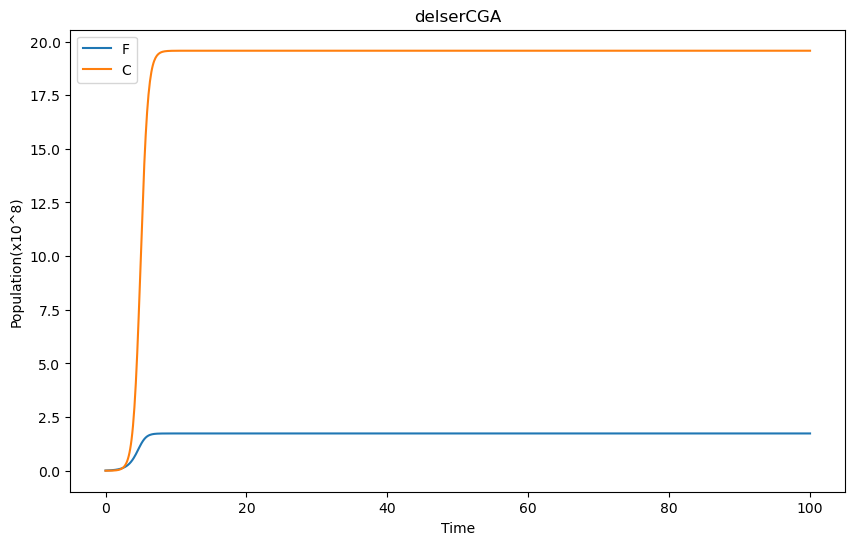

In [425]:
fig, ax = plt.subplots(figsize = (10,6));
test_model.plot_sol(ax)
#ax.axhline(y = 10, xmin=0, xmax=100)


In [475]:
test_mu_cf = np.linspace(4.25e-9, 4.25e-8, 10)
test_r_c = np.linspace(0.1, 2, 10)

For numerical efficiency I will scale down all the equations by 10^8, therefore

In [377]:
4.8*2.4

11.52

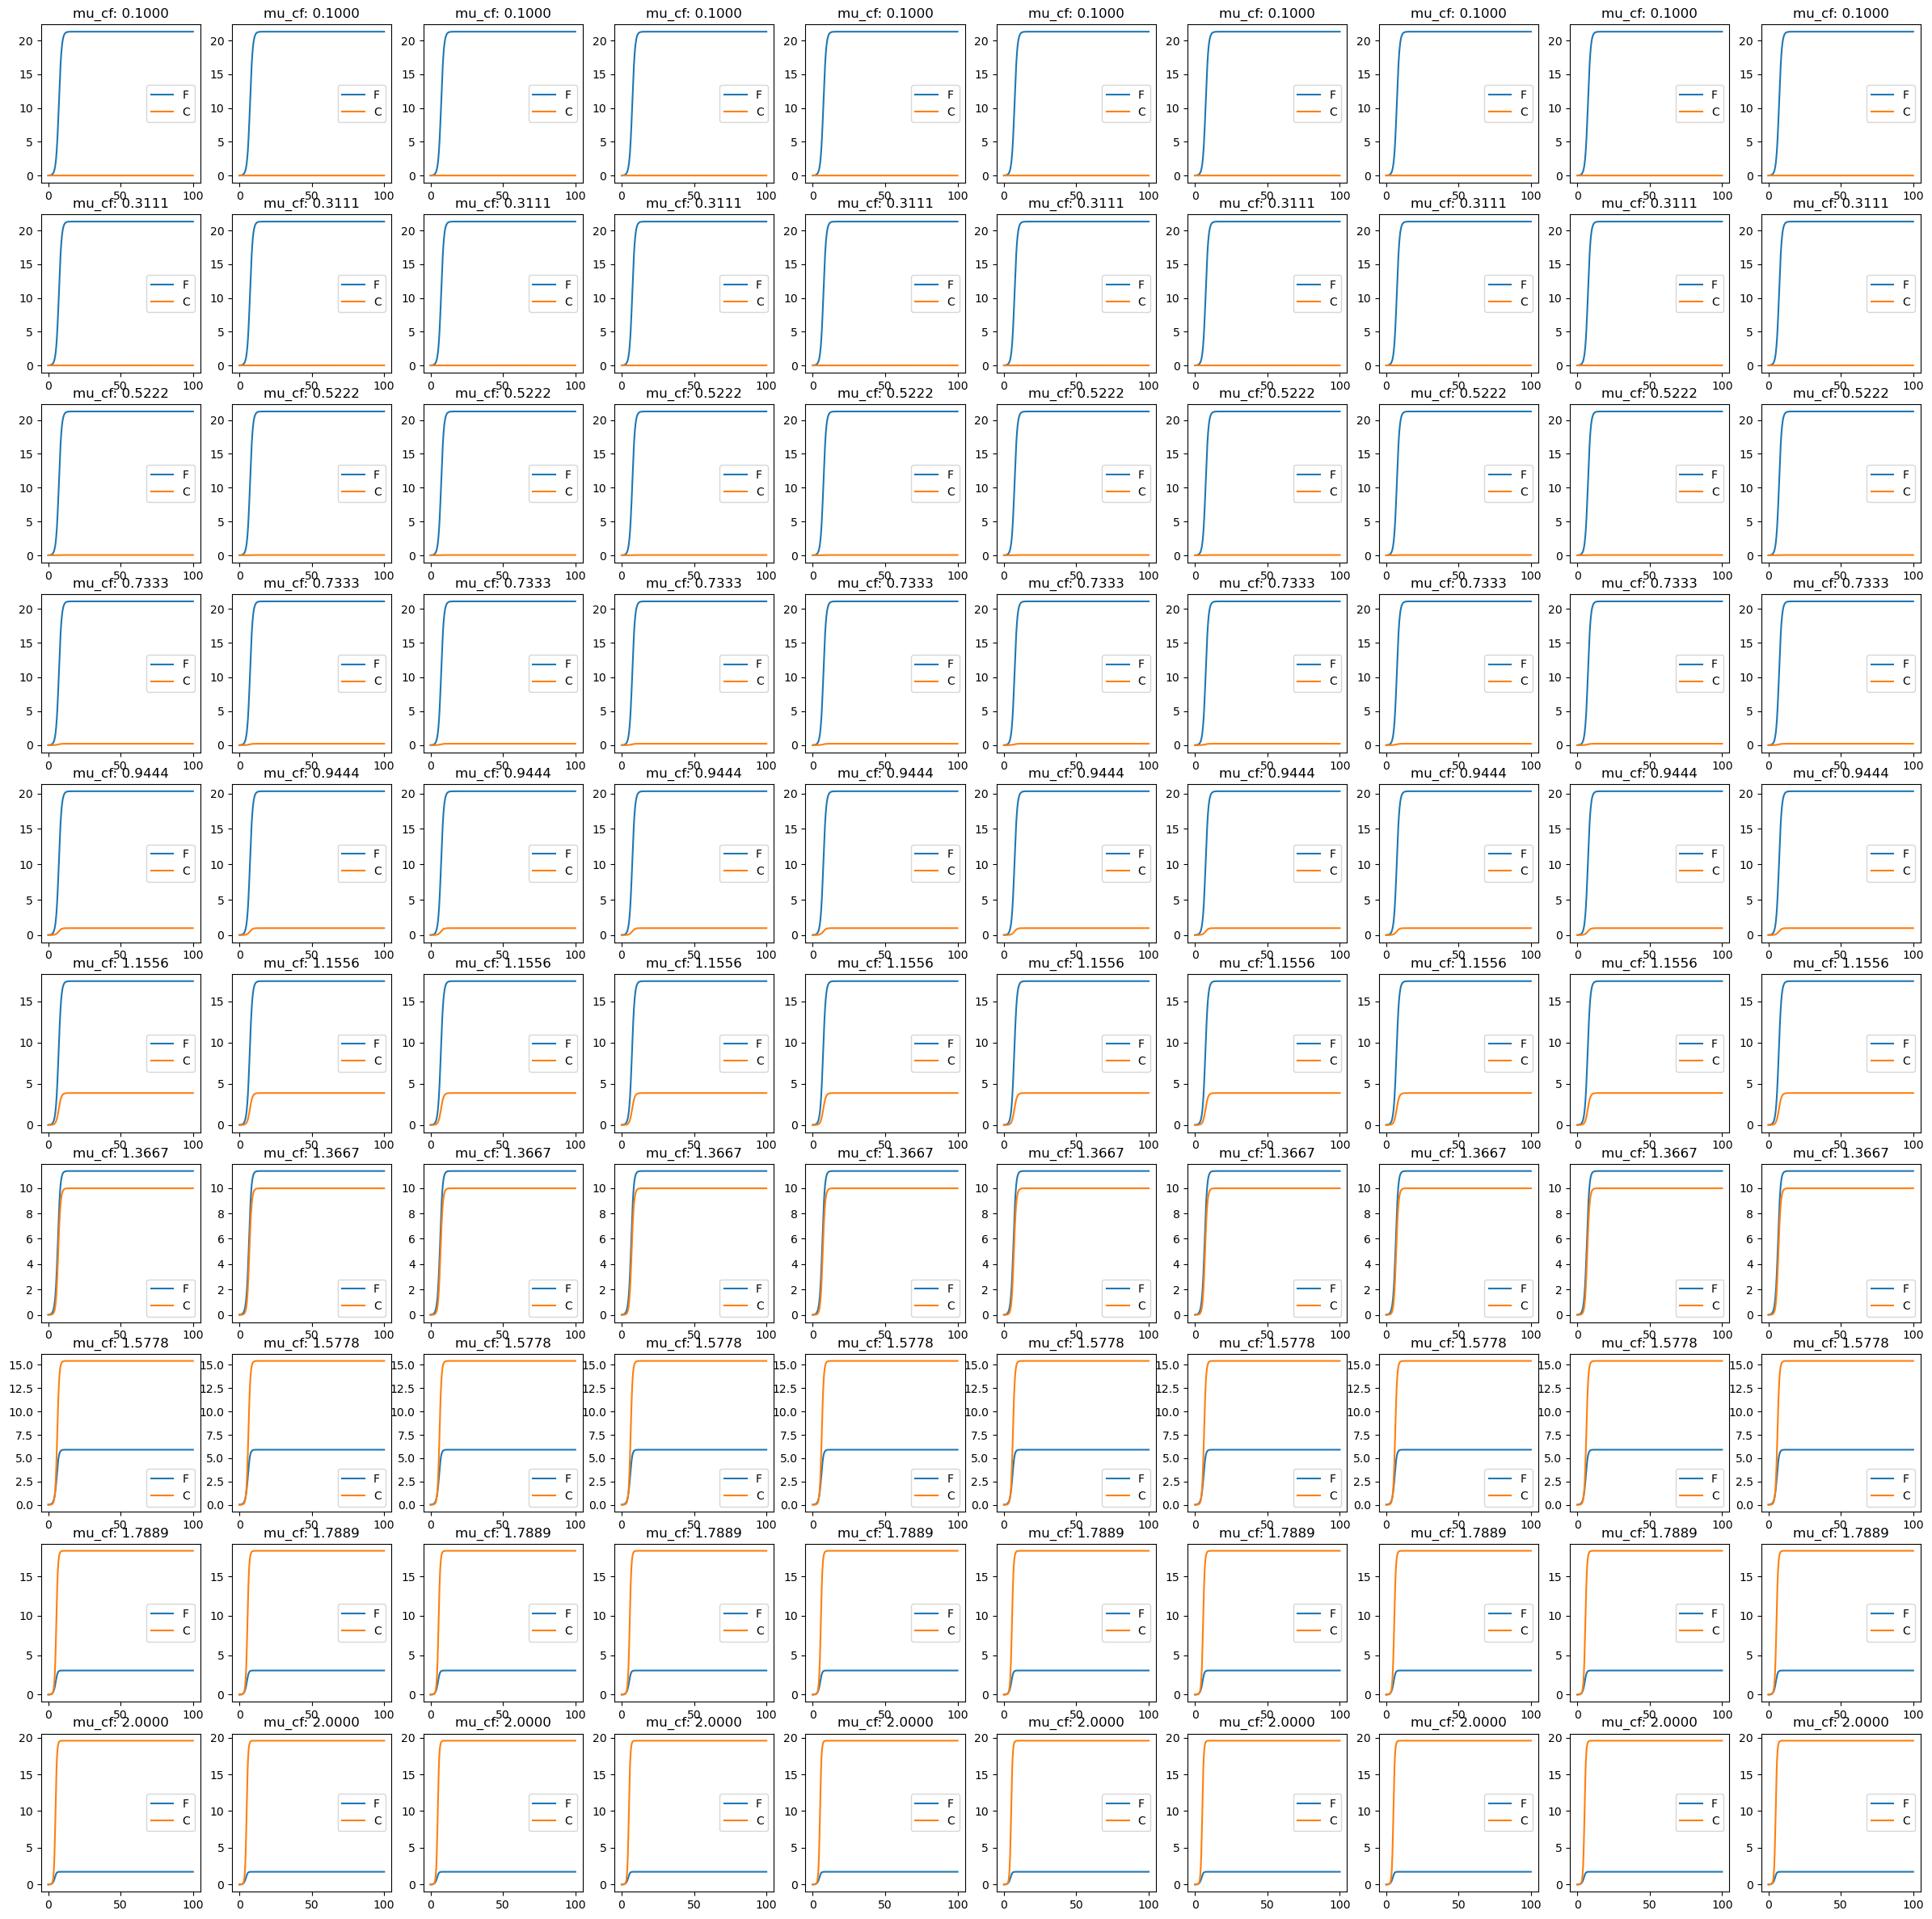

In [476]:
fig, ax = plt.subplots(nrows=10, ncols=10, figsize = (30,30))
test_p0 = np.array([0.01, 0.001])
results = {}
for i, rc in enumerate(test_r_c):
    test_model.r_c = rc
    
    for j, mu in enumerate(test_mu_cf):
        test_model.name = "mu_cf: {:.4f}".format(rc, mu)
        test_model.mu_cf = mu
        test_model.solve(p0 = test_p0)
        test_model.plot_sol(ax[i,j])
    
    ax[i,0].set_ylabel = "r_c: {:.4f}".format(rc)    
        

In [454]:
(test_model.sol / test_model.sol.sum(axis = 1)[:, None]).shape

(1000, 2)

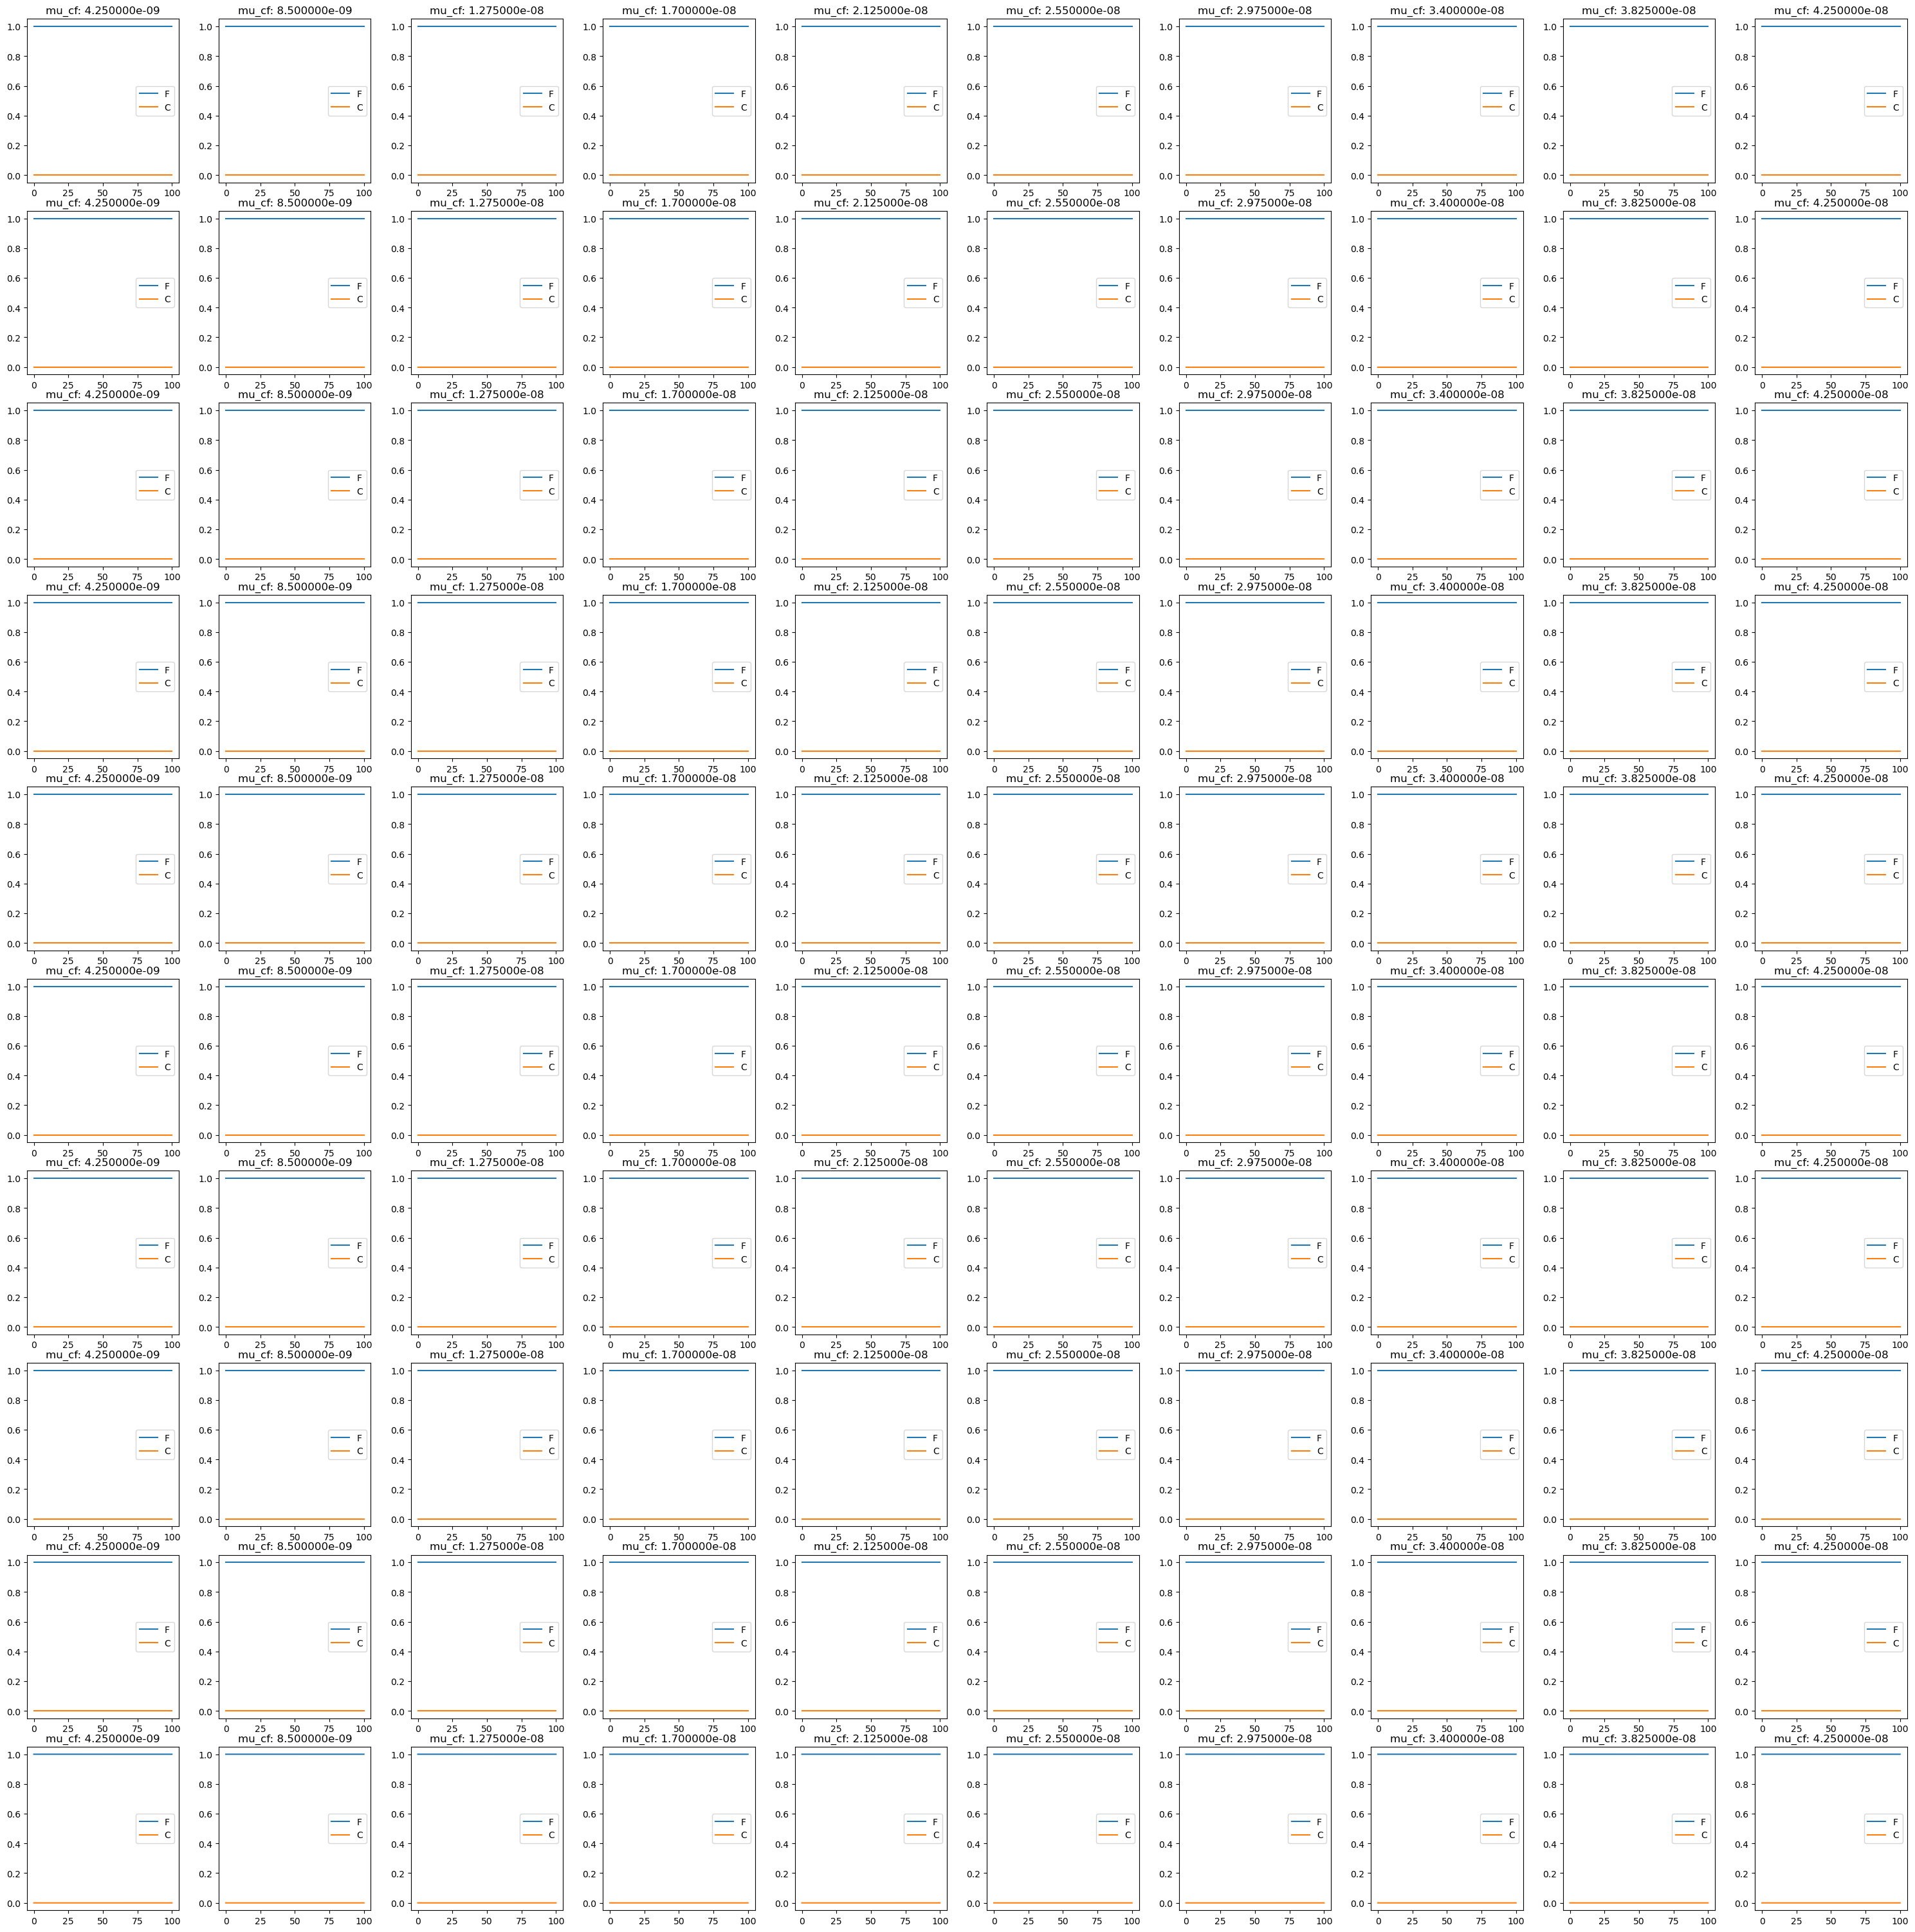

In [477]:
fig, ax = plt.subplots(nrows=10, ncols=10, figsize = (30,30))
plt.tight_layout()
test_p0 = np.array([0.001, 0])
results = {}
for i, rc in enumerate(test_r_c):
    test_model.r_c = rc
    
    for j, mu in enumerate(test_mu_cf):
        test_model.name = "mu_cf: {:e}".format(mu)
        test_model.mu_cf = mu
        test_model.solve(p0 = test_p0)
        test_model.plot_frac(ax[i,j]);
    
    ax[i,0].set_ylabel = "r_c: {:e}".format(rc)    
        

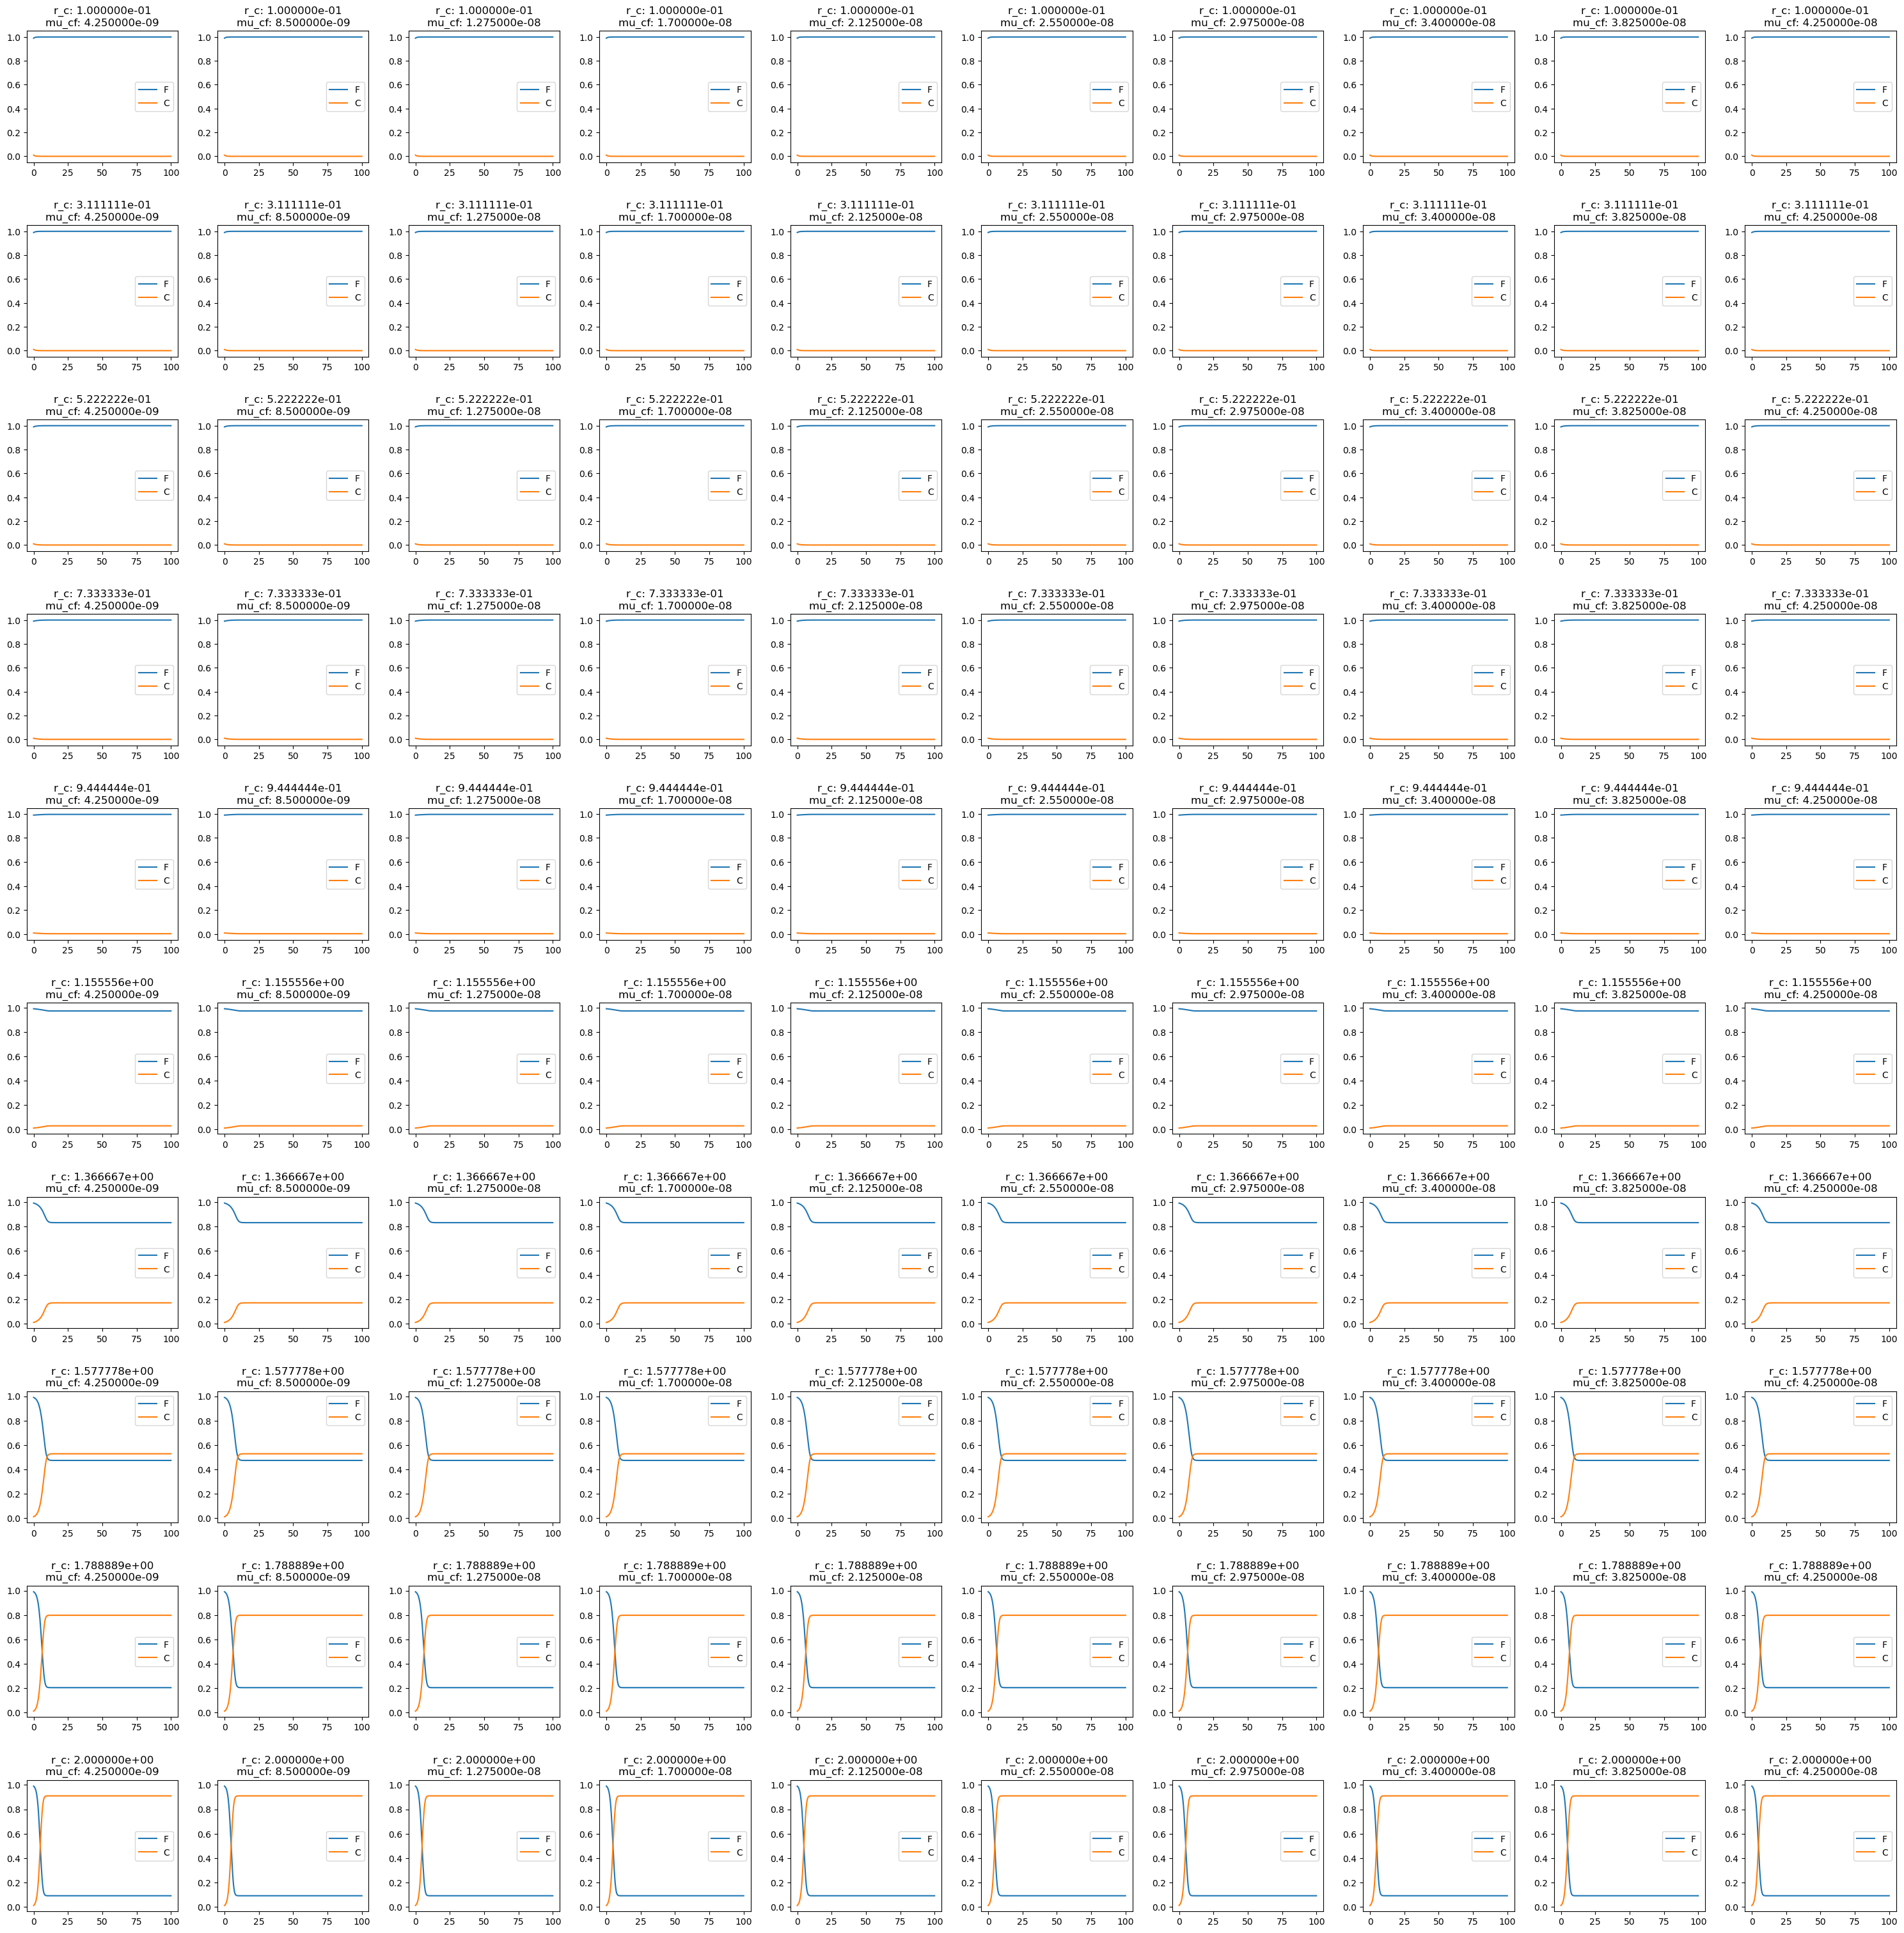

In [478]:
fig, ax = plt.subplots(nrows=10, ncols=10, figsize = (30,30))
fig.tight_layout(h_pad = 5)
test_p0 = np.array([0.001, 0.00001])
results = {}
for i, rc in enumerate(test_r_c):
    test_model.r_c = rc
    
    for j, mu in enumerate(test_mu_cf):
        test_model.name = "r_c: {:e}\nmu_cf: {:e}".format(rc, mu)
        test_model.mu_cf = mu
        test_model.solve(p0 = test_p0)
        test_model.plot_frac(ax[i,j]);
    
    ax[i][0].set_ylabel = "r_c: {:e}".format(rc)    

Let's remove the data with